In [ ]:
from __future__ import print_function
import numpy as np
import math
import matplotlib.pyplot as plt
import os, datetime
from tqdm import tqdm
import json
from matplotlib import image
from PIL import Image
import pathlib
from  glob import glob
import IPython.display as display
from IPython.display import clear_output

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(f"Tensorflow ver. {tf.__version__}")

Tensorflow ver. 2.2.0


In [ ]:
# Deeplabv3+ apply conditional random field(crf), the line below is used to install library support crf
# !pip install pydensecrf

In [ ]:
# Uncomment to clone and import model

# !git clone https://github.com/bonlime/keras-deeplab-v3-plus.git
# %cd /content/keras-deeplab-v3-plus
# from model import Deeplabv3

# Loading data
Mapillary Vistas is stored in our drive. To load data we need to mount drive to colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Now, let's load our data: Mapillary Vistas


In [ ]:
# dir to dataset
dataset_dir = pathlib.Path('/content/drive/My Drive/Mapillary Vistas/')

training_dir = dataset_dir/'training'
validation_dir = dataset_dir/'validation'
test_dir = dataset_dir/'testing'

print('Folders and files in dataset directory:', os.listdir(dataset_dir))
print('Folders in training:', os.listdir(training_dir))
print('Folders in validation:', os.listdir(validation_dir))
print('Folders in testing:', os.listdir(test_dir))

Folders and files in dataset directory: ['Mapillary Vistas Research Edition License.pdf', 'requirements.txt', 'README', 'demo.py', 'MVD_plot.png', '.vscode', 'images for plotting', 'training', 'validation', 'Deeplabv3+', 'segmentation_models', 'PSPNet', 'Models (weight)', 'testing', 'PSPNet (resnet152)', 'config.json']
Folders in training: ['instances', 'panoptic', 'images', 'labels']
Folders in validation: ['images', 'instances', 'labels', 'panoptic']
Folders in testing: ['panoptic', 'labels', 'instances', 'images']


In [ ]:
with open(dataset_dir/'config.json') as config_file:
  config = json.load(config_file)

def apply_color_map(image_array, labels):
    color_array = np.zeros((image_array.shape[0], image_array.shape[1], 3), dtype=np.uint8)
    if len(image_array.shape) == 3:
      image_array = np.reshape(image_array, (image_array.shape[0], image_array.shape[1]))
    for label_id, label in enumerate(labels):
        # set all pixels with the current label to the color of the current label
        color_array[image_array == label_id] = label["color"]
    return color_array

labels = config['labels']

In [ ]:
# Uncomment to see classes.

# for label_id, label in enumerate(labels):
#   print("{:>30} ({:2d}): {:<40} has instances: {}".format(label["readable"], label_id, label["name"], label["instances"]))

In [ ]:
# Image size that we are going to use
IMG_SIZE = 512
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Mapillary has 65 classes + `not labeled`
N_CLASSES = 66

In [ ]:
# train_size = len(glob(str(training_dir/'images/*/*.jpg')))
train_size = 18000
print (train_size)

# val_size = len(glob(str(validation_dir/'images/*.jpg')))
val_size = 2000
print (val_size)

# test_size = len(glob(str(test_dir/'images/*.jpg')))
# print (test_size)

# glob(str(training_dir/'images/*/*.jpg'))

18000
2000


In [ ]:
def parse_image(img_path: str) -> dict:
  """Load an image and its annotation (mask) and returning
  a dictionary.

  Parameters
  ----------
  img_path : str
      Image (not the mask) location.

  Returns
  -------
  dict
      Dictionary mapping an image and its annotation.
  """
  image = tf.io.read_file(img_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image,tf.uint8)

  # For one image path:
  # .../Mapillary Vistas/training/images/AAxRDbsGxOg1q43frAgtWw.jpg
  # It corresponding annotation path is:
  # .../Mapillary Vistas/training/labels/AAxRDbsGxOg1q43frAgtWw.png
  mask_path = tf.strings.regex_replace(img_path, 'images', 'labels')
  mask_path = tf.strings.regex_replace(mask_path, 'jpg$', 'png') # 'jpg#' means just change the 'jpg' at the end of text
  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, channels=3)

  return {'image': image, 'segmentation_mask': mask}

In [ ]:
train_imgs = tf.data.Dataset.list_files(str(training_dir/'images/*/*.jpg'))
val_imgs = tf.data.Dataset.list_files(str(validation_dir/'images/*.jpg'))
# test_imgs = tf.data.Dataset.list_files(str(test_dir/'images/*.jpg'))

train_set = train_imgs.map(parse_image)
val_set = val_imgs.map(parse_image)
# test_set = test_imgs.map(parse_image)
dataset = {'train':train_set, 'valid':val_set,
          #  'test':test_set
           }
dataset

{'train': <MapDataset shapes: {image: (None, None, 3), segmentation_mask: (None, None, 3)}, types: {image: tf.uint8, segmentation_mask: tf.uint8}>,
 'valid': <MapDataset shapes: {image: (None, None, 3), segmentation_mask: (None, None, 3)}, types: {image: tf.uint8, segmentation_mask: tf.uint8}>}

In [ ]:
@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
  """Rescale the pixel values of the images between 0.0 and 1.0
  compared to [0,255] originally.

  Parameters
  ----------
  input_image : tf.Tensor
      Tensorflow tensor containing an image of size [SIZE,SIZE,3].
  input_mask : tf.Tensor
      Tensorflow tensor containing an annotation of size [SIZE,SIZE,1].

  Returns
  -------
  tuple
      Normalized image and its annotation.
  """
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image, input_mask

def sparse_categorical_mask(mask):
  """
  Converts mask to a one-hot encoding specified by the semantic map.
  """
  one_hot_map = []
  for category in config['labels']:
      class_map = tf.reduce_all(tf.equal(mask, category['color']), axis=-1)
      one_hot_map.append(class_map)
  one_hot_map = tf.stack(one_hot_map, axis=-1)
  one_hot_map = tf.cast(one_hot_map, tf.float32)
  sparse_categorical_mask = tf.math.argmax(one_hot_map, axis = -1) # create sparse categorical mask
  sparse_categorical_mask = tf.expand_dims(sparse_categorical_mask, axis = -1) # add 1 dimension to have 3 dimension
  sparse_categorical_mask = tf.cast(sparse_categorical_mask, tf.float32)

  return sparse_categorical_mask

@tf.function
def load_image_train(datapoint: dict) -> tuple:
  """Apply some transformations to an input dictionary
  containing a train image and its annotation.

  Notes
  -----
  An annotation is a regular  channel image.
  If a transformation such as rotation is applied to the image,
  the same transformation has to be applied on the annotation also.

  Parameters
  ----------
  datapoint : dict
      A dict containing an image and its annotation.

  Returns
  -------
  tuple
      A modified image and its annotation.
  """
  input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))
  input_mask = sparse_categorical_mask(input_mask)

  if tf.random.uniform(()) > 0.5:
      input_image = tf.image.flip_left_right(input_image)
      input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

@tf.function
def load_image_test(datapoint: dict) -> tuple:
  """Normalize and resize a test image and its annotation.

  Notes
  -----
  Since this is for the test set, we don't need to apply
  any data augmentation technique.

  Parameters
  ----------
  datapoint : dict
      A dict containing an image and its annotation.

  Returns
  -------
  tuple
      A modified image and its annotation.
  """
  input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))
  input_mask = sparse_categorical_mask(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
BATCH_SIZE = 4
SEED = 42
# for reference about the BUFFER_SIZE in shuffle:
# https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle
BUFFER_SIZE = 1000

dataset = {"train": train_set, "val": val_set}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

print(dataset['train'])
print(dataset['val'])

<PrefetchDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 1)), types: (tf.float32, tf.float32)>


In [ ]:
def display_sample(display_list):
  """Show side-by-side an input image,
  the ground truth and the prediction.
  """
  plt.figure(figsize=(18, 18))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), )
    plt.axis('off')
  plt.show()

1it [00:06,  6.52s/it]


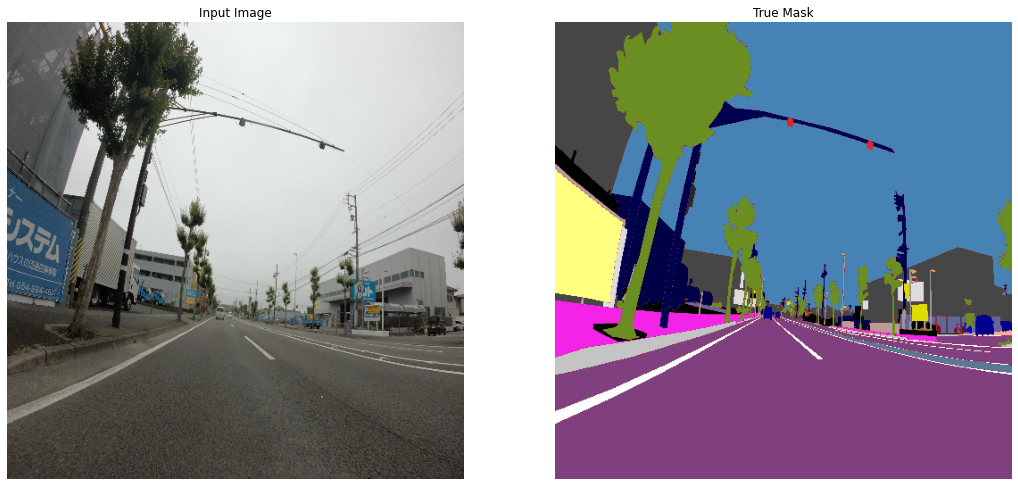

In [ ]:
for image, mask in tqdm(dataset['val'].take(1)):
    sample_image, sample_mask = image, mask
display_sample([sample_image[0], apply_color_map(sample_mask[0], labels)])

In [ ]:
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:

    # pred_mask -> [IMG_SIZE, SIZE, N_CLASS]
    # 1 prediction for each class but we want the highest score only
    # so we use argmax
    pred_mask = tf.argmax(pred_mask, axis=-1)
    # pred_mask becomes [IMG_SIZE, IMG_SIZE]
    pred_mask = (tf.make_ndarray(tf.make_tensor_proto(pred_mask)))
    pred_mask = apply_color_map(pred_mask[0], labels)
    return pred_mask

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], mask, create_mask(pred_mask)])
    else:
        # The model is expecting a tensor of the size
        # [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3]
        # but sample_image[0] is [IMG_SIZE, IMG_SIZE, 3]
        # and we want only 1 inference to be faster
        # so we add an additional dimension [1, IMG_SIZE, IMG_SIZE, 3]
        one_img_batch = sample_image[0][tf.newaxis, ...]

        mask = tf.make_ndarray(tf.make_tensor_proto(sample_mask[0]))
        # print(tf.shape(mask))
        # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
        inference = model.predict(one_img_batch)
        # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
        pred_mask = create_mask(inference)
        # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
        display_sample([sample_image[0], apply_color_map(mask, labels),
                        pred_mask])
        return (pred_mask, sample_mask)

In [ ]:
# tf.metrics.MeanIoU throws dimensions mismatch error when used with SparseCategoricalCrossEntropy, link: https://github.com/tensorflow/tensorflow/issues/39586
# this is a workaround to use MeanIoU
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

In [ ]:
from sklearn.utils import class_weight

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

path = 'Deeplabv3+RectifiedAdam'

# class_weight = class_weight.compute_class_weight('balanced'
#                                                ,np.unique(dataset['train'].take(train_size // BATCH_SIZE)[1])
#                                                ,Y_train)

callbacks = [
    # to show samples after each epoch
    DisplayCallback(), #uncomment this line to visualize prediction after each batch
    # to collect some useful metrics and visualize them in tensorboard
    tensorboard_callback,
    # if no val_loss drop reduces the learning rate
    reduceLROnPlateau,
    # if no accuracy improvements we can stop the training directly
    tf.keras.callbacks.EarlyStopping(patience=7, verbose=1),
    # to save checkpoints
    tf.keras.callbacks.ModelCheckpoint(path + 'best_model_deeplabv3+.h5', verbose=1, save_best_only=True, save_weights_only=True),
    # save the last weight, so that we do not loose training progress
    tf.keras.callbacks.ModelCheckpoint(path + 'last_weight.h5', verbose=1, save_weights_only=True),
]

# model.compile(optimizer = 'Adam',
#                     loss = tf.keras.losses.SparseCategoricalCrossentropy(),
#                     metrics=['accuracy',
#                              UpdatedMeanIoU(num_classes= N_CLASSES)
#                              ])

In [ ]:
%cd /content/drive/My Drive/Mapillary Vistas/Deeplabv3+
from model import Deeplabv3
model = Deeplabv3(input_shape=(IMG_SIZE, IMG_SIZE, N_CHANNELS), classes=N_CLASSES, backbone='xception', activation=None)
model.summary()

/content/drive/My Drive/Mapillary Vistas/Deeplabv3+
166100992/166096424 [==============================] - 5s 0us/step
Model: "deeplabv3plus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
entry_flow_conv1_1 (Conv2D)     (None, 256, 256, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
entry_flow_conv1_1_BN (BatchNor (None, 256, 256, 32) 128         entry_flow_conv1_1[0][0]         
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           e

In [ ]:
EPOCHS = 15

STEPS_PER_EPOCH = train_size // BATCH_SIZE
VALIDATION_STEPS = val_size // BATCH_SIZE

Epoch 1/15
4500/4500 [==============================] - ETA: 0s - loss: 0.7412 - accuracy: 0.8029 - updated_mean_io_u_1: 0.1535

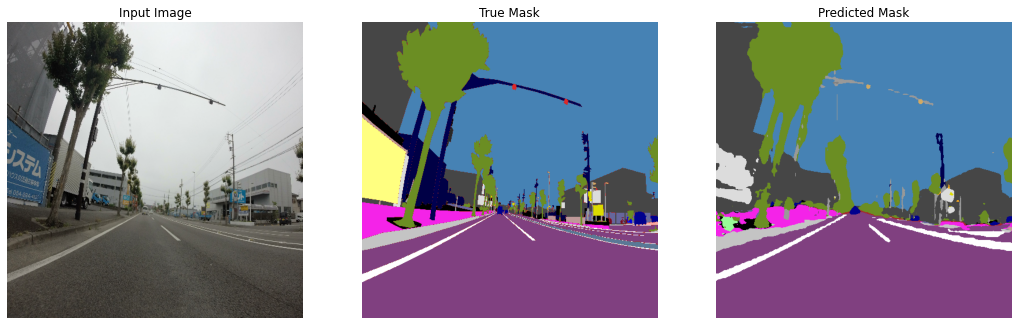


Sample Prediction after epoch 1


Epoch 00001: val_loss improved from inf to 0.61444, saving model to Deeplabv3+RectifiedAdambest_model_deeplabv3+.h5

Epoch 00001: saving model to Deeplabv3+RectifiedAdamlast_weight.h5
4500/4500 [==============================] - 7243s 2s/step - loss: 0.7412 - accuracy: 0.8029 - updated_mean_io_u_1: 0.1535 - val_loss: 0.6144 - val_accuracy: 0.8287 - val_updated_mean_io_u_1: 0.1899 - lr: 0.0010
Epoch 2/15
4500/4500 [==============================] - ETA: 0s - loss: 0.5830 - accuracy: 0.8374 - updated_mean_io_u_1: 0.2038

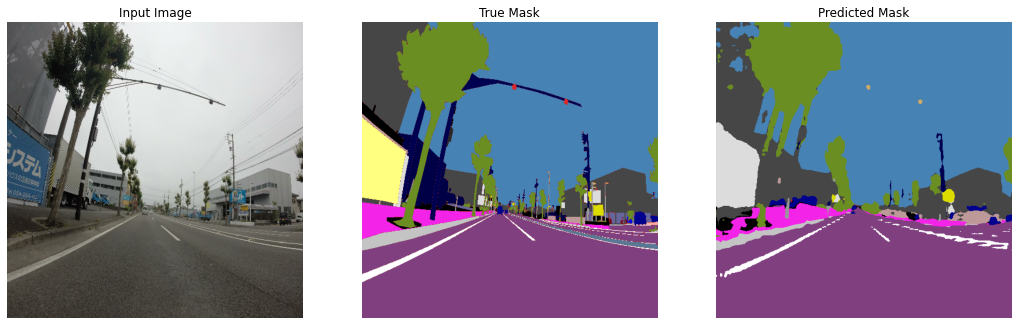


Sample Prediction after epoch 2


Epoch 00002: val_loss improved from 0.61444 to 0.54732, saving model to Deeplabv3+RectifiedAdambest_model_deeplabv3+.h5

Epoch 00002: saving model to Deeplabv3+RectifiedAdamlast_weight.h5
4500/4500 [==============================] - 7236s 2s/step - loss: 0.5830 - accuracy: 0.8374 - updated_mean_io_u_1: 0.2038 - val_loss: 0.5473 - val_accuracy: 0.8432 - val_updated_mean_io_u_1: 0.2288 - lr: 0.0010
Epoch 3/15
4500/4500 [==============================] - ETA: 0s - loss: 0.5196 - accuracy: 0.8523 - updated_mean_io_u_1: 0.2365

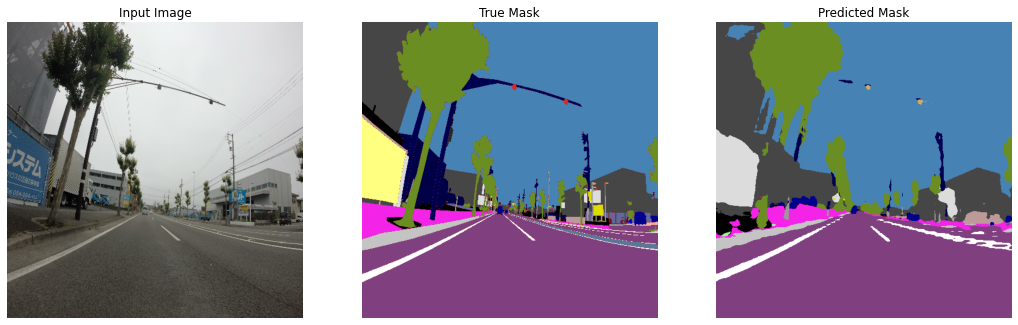


Sample Prediction after epoch 3


Epoch 00003: val_loss did not improve from 0.54732

Epoch 00003: saving model to Deeplabv3+RectifiedAdamlast_weight.h5
4500/4500 [==============================] - 7195s 2s/step - loss: 0.5196 - accuracy: 0.8523 - updated_mean_io_u_1: 0.2365 - val_loss: 0.6085 - val_accuracy: 0.8484 - val_updated_mean_io_u_1: 0.2531 - lr: 0.0010
Epoch 4/15
4500/4500 [==============================] - ETA: 0s - loss: 0.4745 - accuracy: 0.8629 - updated_mean_io_u_1: 0.2647

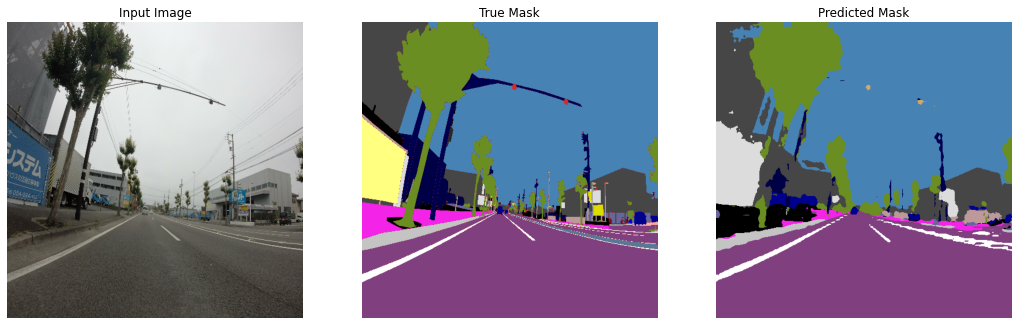


Sample Prediction after epoch 4


Epoch 00004: val_loss improved from 0.54732 to 0.47866, saving model to Deeplabv3+RectifiedAdambest_model_deeplabv3+.h5

Epoch 00004: saving model to Deeplabv3+RectifiedAdamlast_weight.h5
4500/4500 [==============================] - 6927s 2s/step - loss: 0.4745 - accuracy: 0.8629 - updated_mean_io_u_1: 0.2647 - val_loss: 0.4787 - val_accuracy: 0.8603 - val_updated_mean_io_u_1: 0.2785 - lr: 0.0010
Epoch 5/15
4500/4500 [==============================] - ETA: 0s - loss: 0.4448 - accuracy: 0.8700 - updated_mean_io_u_1: 0.2864

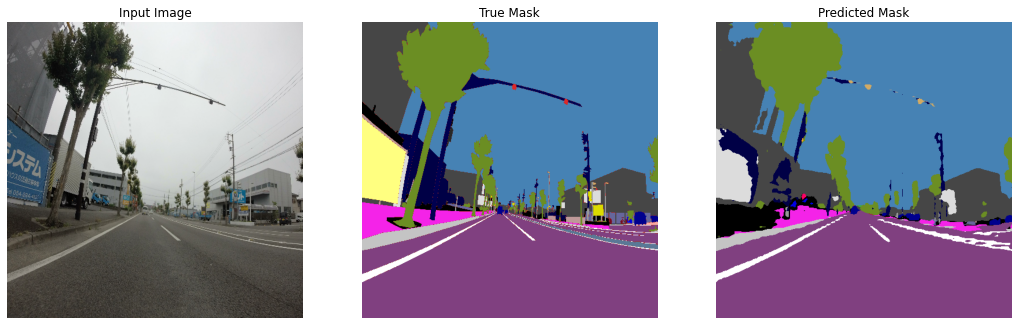


Sample Prediction after epoch 5


Epoch 00005: val_loss improved from 0.47866 to 0.45588, saving model to Deeplabv3+RectifiedAdambest_model_deeplabv3+.h5

Epoch 00005: saving model to Deeplabv3+RectifiedAdamlast_weight.h5
4500/4500 [==============================] - 6893s 2s/step - loss: 0.4448 - accuracy: 0.8700 - updated_mean_io_u_1: 0.2864 - val_loss: 0.4559 - val_accuracy: 0.8676 - val_updated_mean_io_u_1: 0.2954 - lr: 0.0010
Epoch 6/15
4500/4500 [==============================] - ETA: 0s - loss: 0.4186 - accuracy: 0.8765 - updated_mean_io_u_1: 0.3068

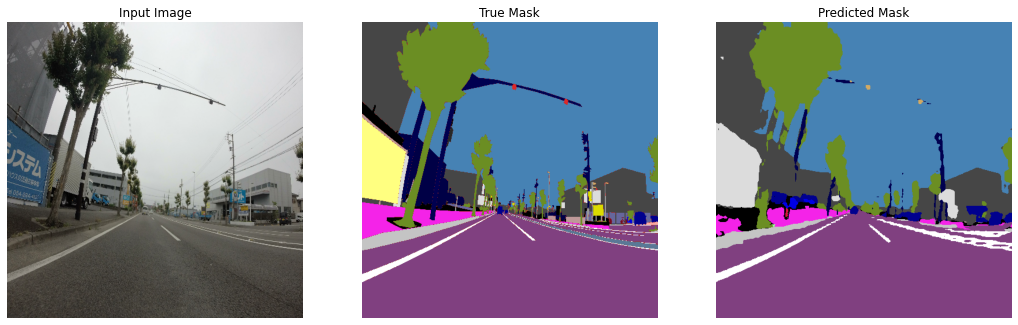


Sample Prediction after epoch 6


Epoch 00006: val_loss improved from 0.45588 to 0.45115, saving model to Deeplabv3+RectifiedAdambest_model_deeplabv3+.h5

Epoch 00006: saving model to Deeplabv3+RectifiedAdamlast_weight.h5
4500/4500 [==============================] - 6837s 2s/step - loss: 0.4186 - accuracy: 0.8765 - updated_mean_io_u_1: 0.3068 - val_loss: 0.4512 - val_accuracy: 0.8691 - val_updated_mean_io_u_1: 0.3048 - lr: 0.0010
Epoch 7/15
4500/4500 [==============================] - ETA: 0s - loss: 0.3994 - accuracy: 0.8818 - updated_mean_io_u_1: 0.3247

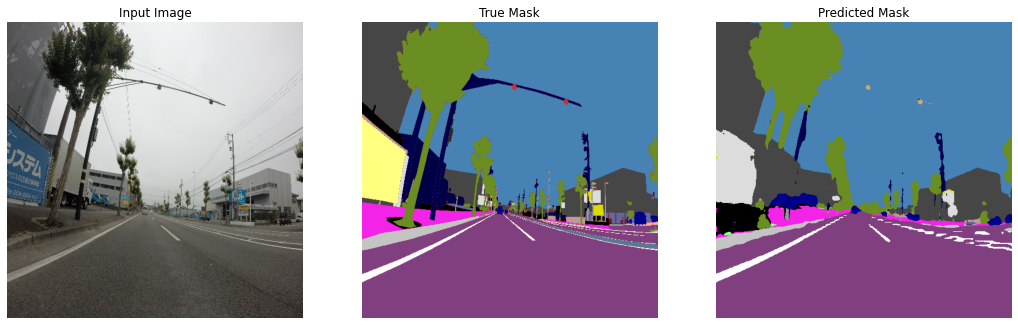


Sample Prediction after epoch 7


Epoch 00007: val_loss improved from 0.45115 to 0.44237, saving model to Deeplabv3+RectifiedAdambest_model_deeplabv3+.h5

Epoch 00007: saving model to Deeplabv3+RectifiedAdamlast_weight.h5
4500/4500 [==============================] - 6998s 2s/step - loss: 0.3994 - accuracy: 0.8818 - updated_mean_io_u_1: 0.3247 - val_loss: 0.4424 - val_accuracy: 0.8712 - val_updated_mean_io_u_1: 0.3095 - lr: 0.0010
Epoch 8/15
4500/4500 [==============================] - ETA: 0s - loss: 0.3800 - accuracy: 0.8865 - updated_mean_io_u_1: 0.3415

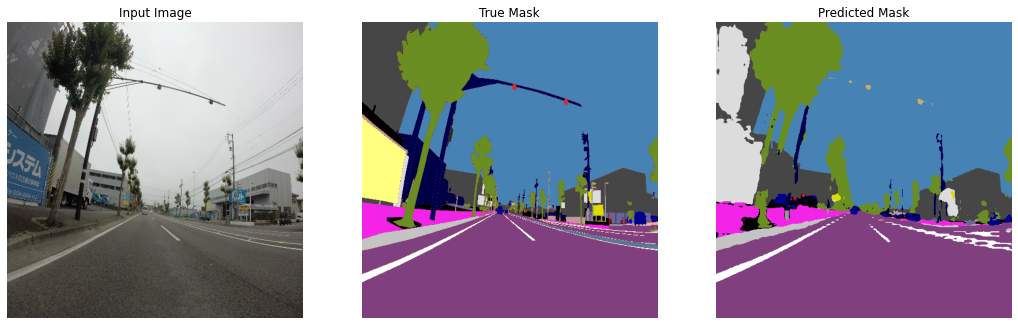


Sample Prediction after epoch 8


Epoch 00008: val_loss improved from 0.44237 to 0.42879, saving model to Deeplabv3+RectifiedAdambest_model_deeplabv3+.h5

Epoch 00008: saving model to Deeplabv3+RectifiedAdamlast_weight.h5
4500/4500 [==============================] - 7025s 2s/step - loss: 0.3800 - accuracy: 0.8865 - updated_mean_io_u_1: 0.3415 - val_loss: 0.4288 - val_accuracy: 0.8738 - val_updated_mean_io_u_1: 0.3225 - lr: 0.0010
Epoch 9/15
4500/4500 [==============================] - ETA: 0s - loss: 0.3638 - accuracy: 0.8911 - updated_mean_io_u_1: 0.3609

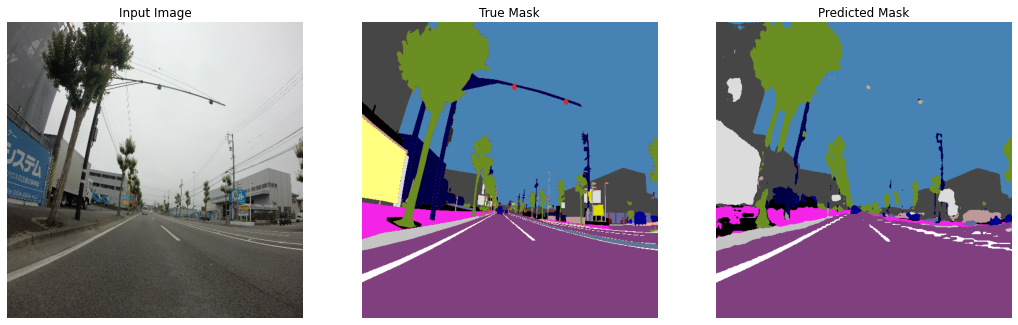


Sample Prediction after epoch 9


Epoch 00009: val_loss did not improve from 0.42879

Epoch 00009: saving model to Deeplabv3+RectifiedAdamlast_weight.h5
4500/4500 [==============================] - 6924s 2s/step - loss: 0.3638 - accuracy: 0.8911 - updated_mean_io_u_1: 0.3609 - val_loss: 0.4314 - val_accuracy: 0.8729 - val_updated_mean_io_u_1: 0.3264 - lr: 0.0010
Epoch 10/15
4500/4500 [==============================] - ETA: 0s - loss: 0.3493 - accuracy: 0.8947 - updated_mean_io_u_1: 0.3759

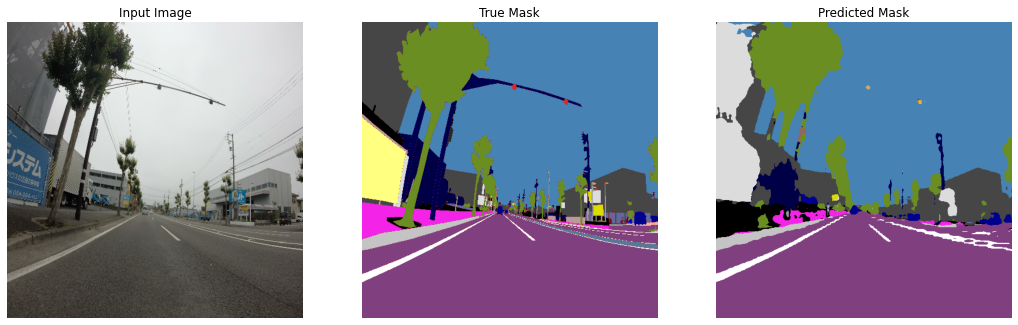


Sample Prediction after epoch 10


Epoch 00010: val_loss did not improve from 0.42879

Epoch 00010: saving model to Deeplabv3+RectifiedAdamlast_weight.h5
4500/4500 [==============================] - 6949s 2s/step - loss: 0.3493 - accuracy: 0.8947 - updated_mean_io_u_1: 0.3759 - val_loss: 0.4535 - val_accuracy: 0.8762 - val_updated_mean_io_u_1: 0.3287 - lr: 0.0010
Epoch 11/15
 568/4500 [==>...........................] - ETA: 55:34 - loss: 0.3258 - accuracy: 0.9017 - updated_mean_io_u_1: 0.3954

In [ ]:
model.compile(optimizer = tfa.optimizers.RectifiedAdam(lr=1e-3),
                    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # activation of the last layer is None, so SparseCategoricalCrossentropy expect predicted mask are value of logits
                    metrics=['accuracy',
                             UpdatedMeanIoU(num_classes= N_CLASSES)
                             ])
model_history = model.fit(dataset['train'],
                                epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=VALIDATION_STEPS,
                    validation_data=dataset['val'],
                    callbacks=callbacks
                    )

Epoch 1/15
4500/4500 [==============================] - ETA: 0s - loss: 0.3951 - accuracy: 0.8827 - updated_mean_io_u: 0.3241

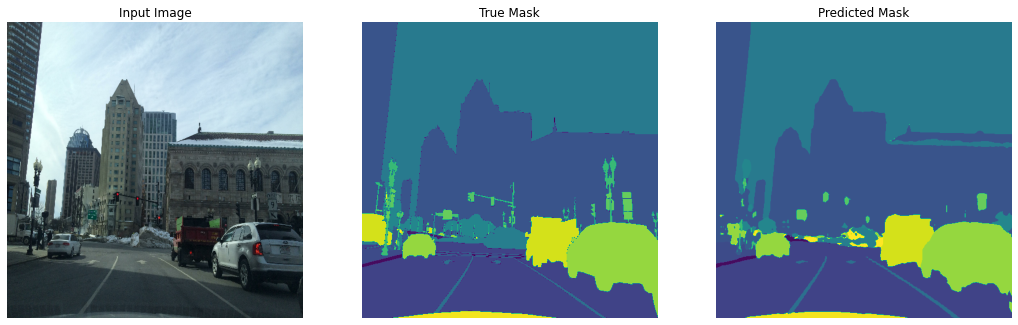


Sample Prediction after epoch 1


Epoch 00001: val_loss improved from inf to 0.45073, saving model to best_model_deeplabv3+.h5

Epoch 00001: saving model to last_weight.h5
4500/4500 [==============================] - 8918s 2s/step - loss: 0.3951 - accuracy: 0.8827 - updated_mean_io_u: 0.3241 - val_loss: 0.4507 - val_accuracy: 0.8676 - val_updated_mean_io_u: 0.3165 - lr: 0.0010
Epoch 2/15
4500/4500 [==============================] - ETA: 0s - loss: 0.3784 - accuracy: 0.8871 - updated_mean_io_u: 0.3389

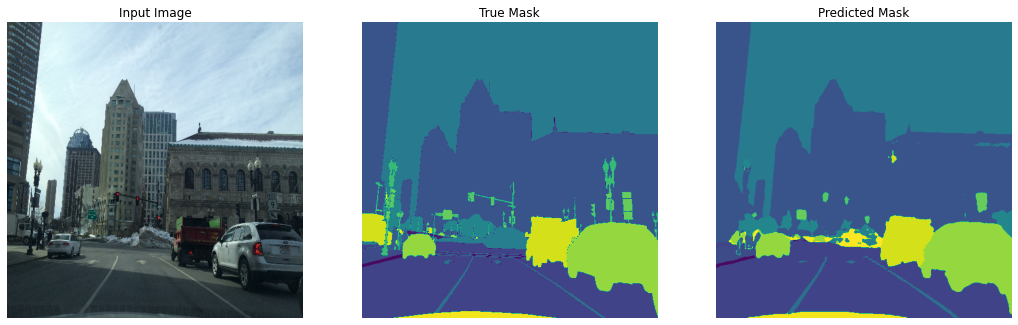


Sample Prediction after epoch 2


Epoch 00002: val_loss improved from 0.45073 to 0.44674, saving model to best_model_deeplabv3+.h5

Epoch 00002: saving model to last_weight.h5
4500/4500 [==============================] - 8059s 2s/step - loss: 0.3784 - accuracy: 0.8871 - updated_mean_io_u: 0.3389 - val_loss: 0.4467 - val_accuracy: 0.8700 - val_updated_mean_io_u: 0.3136 - lr: 0.0010
Epoch 3/15
4500/4500 [==============================] - ETA: 0s - loss: 0.3643 - accuracy: 0.8908 - updated_mean_io_u: 0.3561

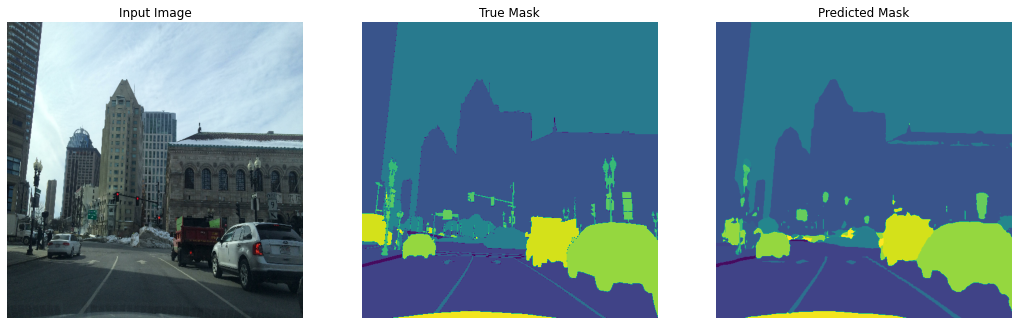


Sample Prediction after epoch 3


Epoch 00003: val_loss improved from 0.44674 to 0.42383, saving model to best_model_deeplabv3+.h5

Epoch 00003: saving model to last_weight.h5
4500/4500 [==============================] - 7546s 2s/step - loss: 0.3643 - accuracy: 0.8908 - updated_mean_io_u: 0.3561 - val_loss: 0.4238 - val_accuracy: 0.8766 - val_updated_mean_io_u: 0.3345 - lr: 0.0010
Epoch 4/15
4500/4500 [==============================] - ETA: 0s - loss: 0.3505 - accuracy: 0.8949 - updated_mean_io_u: 0.3699

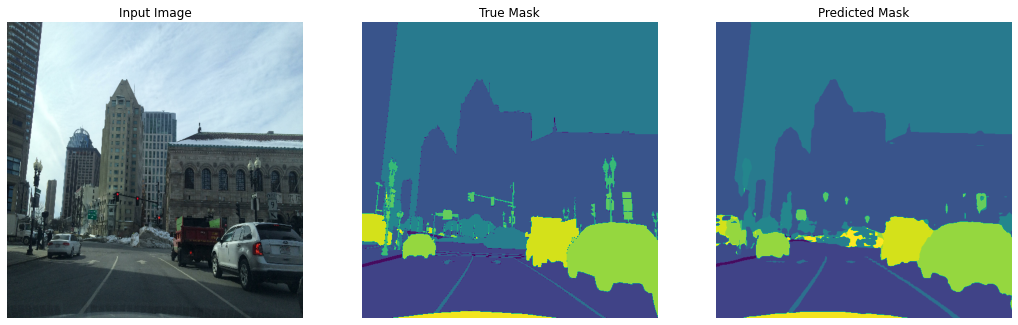


Sample Prediction after epoch 4


Epoch 00004: val_loss did not improve from 0.42383

Epoch 00004: saving model to last_weight.h5
4500/4500 [==============================] - 7286s 2s/step - loss: 0.3505 - accuracy: 0.8949 - updated_mean_io_u: 0.3699 - val_loss: 0.4285 - val_accuracy: 0.8751 - val_updated_mean_io_u: 0.3306 - lr: 0.0010
Epoch 5/15
4500/4500 [==============================] - ETA: 0s - loss: 0.3386 - accuracy: 0.8979 - updated_mean_io_u: 0.3844

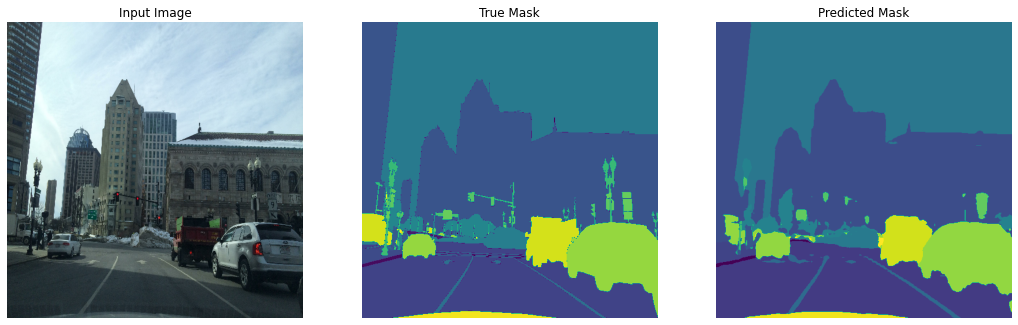


Sample Prediction after epoch 5


Epoch 00005: val_loss improved from 0.42383 to 0.42376, saving model to best_model_deeplabv3+.h5

Epoch 00005: saving model to last_weight.h5
4500/4500 [==============================] - 7189s 2s/step - loss: 0.3386 - accuracy: 0.8979 - updated_mean_io_u: 0.3844 - val_loss: 0.4238 - val_accuracy: 0.8773 - val_updated_mean_io_u: 0.3362 - lr: 0.0010
Epoch 6/15
4500/4500 [==============================] - ETA: 0s - loss: 0.3266 - accuracy: 0.9014 - updated_mean_io_u: 0.3987

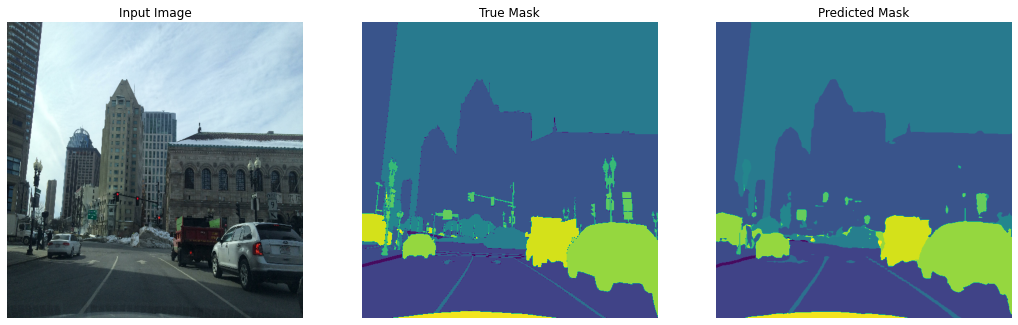


Sample Prediction after epoch 6


Epoch 00006: val_loss did not improve from 0.42376

Epoch 00006: saving model to last_weight.h5
4500/4500 [==============================] - 7637s 2s/step - loss: 0.3266 - accuracy: 0.9014 - updated_mean_io_u: 0.3987 - val_loss: 0.4351 - val_accuracy: 0.8764 - val_updated_mean_io_u: 0.3425 - lr: 0.0010
Epoch 7/15
4500/4500 [==============================] - ETA: 0s - loss: 0.3187 - accuracy: 0.9037 - updated_mean_io_u: 0.4070

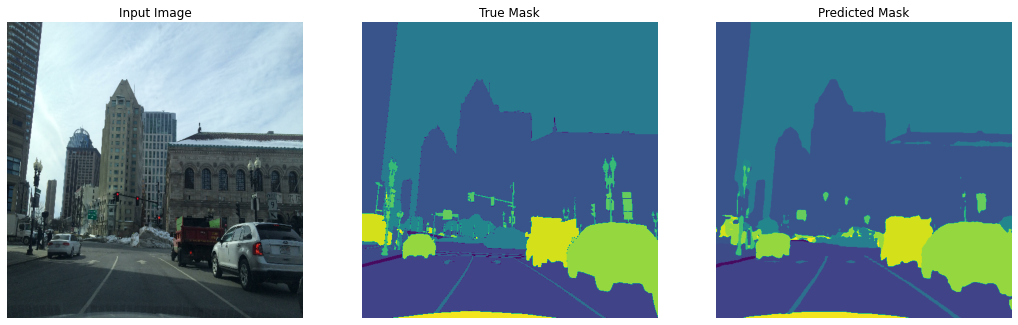


Sample Prediction after epoch 7


Epoch 00007: val_loss improved from 0.42376 to 0.42123, saving model to best_model_deeplabv3+.h5

Epoch 00007: saving model to last_weight.h5
4500/4500 [==============================] - 10059s 2s/step - loss: 0.3187 - accuracy: 0.9037 - updated_mean_io_u: 0.4070 - val_loss: 0.4212 - val_accuracy: 0.8795 - val_updated_mean_io_u: 0.3471 - lr: 0.0010
Epoch 8/15
4500/4500 [==============================] - ETA: 0s - loss: 0.3069 - accuracy: 0.9069 - updated_mean_io_u: 0.4244

In [ ]:
model.load_weights('best_model_deeplabv3+.h5')
model.compile(optimizer = 'Adam',
              # tfa.optimizers.RectifiedAdam(lr=1e-3),
                    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy',
                             UpdatedMeanIoU(num_classes= N_CLASSES)
                             ])
model_history1 = model.fit(dataset['train'],
                                epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=VALIDATION_STEPS,
                    validation_data=dataset['val'],
                    callbacks=callbacks
                    )

In [ ]:
!tensorboard dev upload --logdir /content/drive/My\ Drive/Mapillary\ Vistas/Deeplabv3+/logs/20200604-011257 \
  --name "Deeplabv3+ (Xception) on Mapillary Vistas (public version)" \
  --description "Training results from https://colab.research.google.com/drive/1PMeOrsJ3BFoIFJX_HHD017lFhbZP694K?authuser=1#scrollTo=OQslETqTolqz"

2020-06-04 22:46:51.480853: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/drive/My Drive/Mapillary Vistas/Deeplabv3+/logs/20200604-011257

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleu

Epoch 1/15
4500/4500 [==============================] - ETA: 0s - loss: 0.3081 - accuracy: 0.9067 - updated_mean_io_u: 0.4206

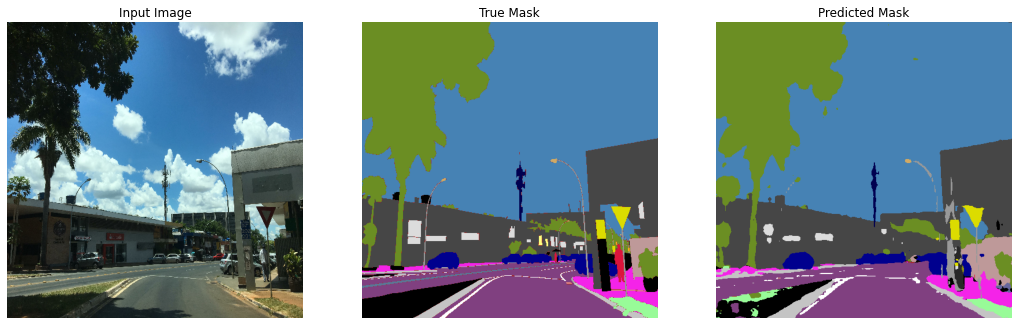


Sample Prediction after epoch 1


Epoch 00001: val_loss improved from inf to 0.43363, saving model to best_model_deeplabv3+.h5

Epoch 00001: saving model to last_weight.h5
4500/4500 [==============================] - 7184s 2s/step - loss: 0.3081 - accuracy: 0.9067 - updated_mean_io_u: 0.4206 - val_loss: 0.4336 - val_accuracy: 0.8765 - val_updated_mean_io_u: 0.3422 - lr: 0.0010
Epoch 2/15
4500/4500 [==============================] - ETA: 0s - loss: 0.2982 - accuracy: 0.9095 - updated_mean_io_u: 0.4355

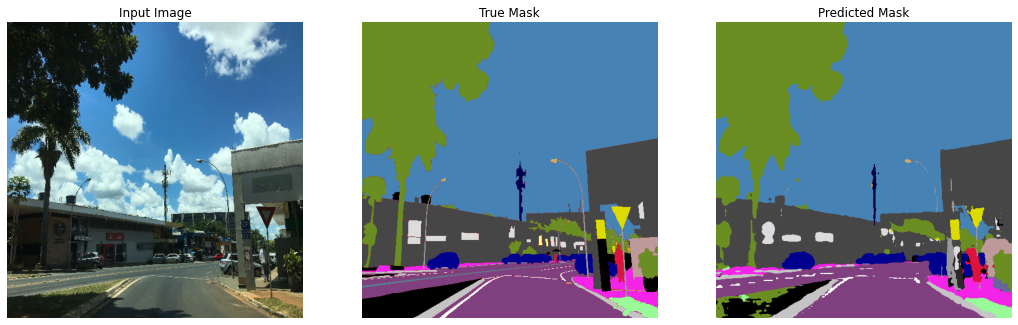


Sample Prediction after epoch 2


Epoch 00002: val_loss did not improve from 0.43363

Epoch 00002: saving model to last_weight.h5
4500/4500 [==============================] - 6667s 1s/step - loss: 0.2982 - accuracy: 0.9095 - updated_mean_io_u: 0.4355 - val_loss: 0.4339 - val_accuracy: 0.8786 - val_updated_mean_io_u: 0.3424 - lr: 0.0010
Epoch 3/15
4500/4500 [==============================] - ETA: 0s - loss: 0.2921 - accuracy: 0.9112 - updated_mean_io_u: 0.4459

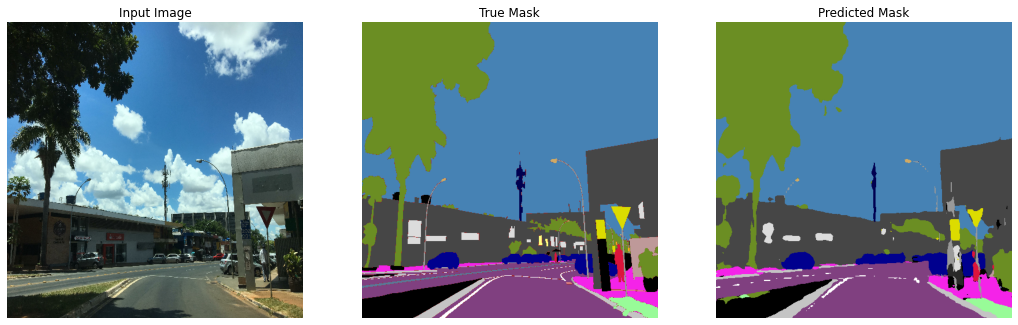


Sample Prediction after epoch 3


Epoch 00003: val_loss did not improve from 0.43363

Epoch 00003: saving model to last_weight.h5
4500/4500 [==============================] - 6624s 1s/step - loss: 0.2921 - accuracy: 0.9112 - updated_mean_io_u: 0.4459 - val_loss: 0.4369 - val_accuracy: 0.8782 - val_updated_mean_io_u: 0.3533 - lr: 0.0010
Epoch 4/15
4500/4500 [==============================] - ETA: 0s - loss: 0.2806 - accuracy: 0.9145 - updated_mean_io_u: 0.4618

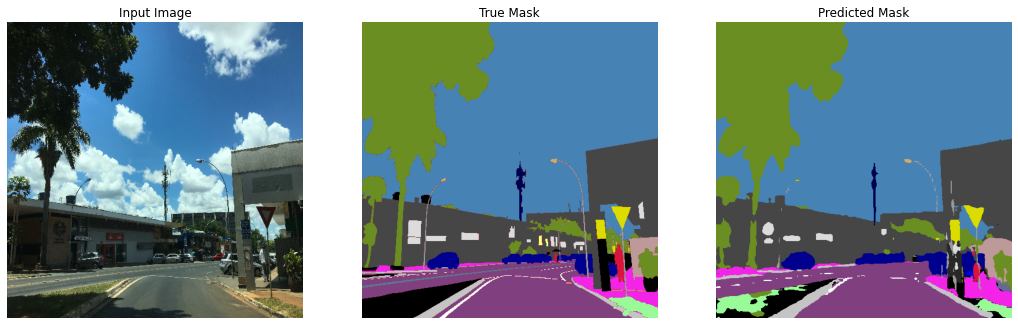


Sample Prediction after epoch 4


Epoch 00004: val_loss did not improve from 0.43363

Epoch 00004: saving model to last_weight.h5
4500/4500 [==============================] - 6747s 1s/step - loss: 0.2806 - accuracy: 0.9145 - updated_mean_io_u: 0.4618 - val_loss: 0.4480 - val_accuracy: 0.8775 - val_updated_mean_io_u: 0.3459 - lr: 0.0010
Epoch 5/15
4500/4500 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.9164 - updated_mean_io_u: 0.4743

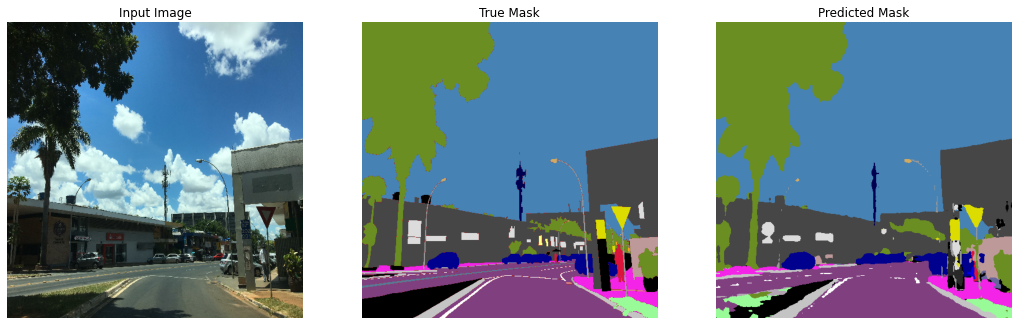


Sample Prediction after epoch 5


Epoch 00005: val_loss did not improve from 0.43363

Epoch 00005: saving model to last_weight.h5
4500/4500 [==============================] - 7083s 2s/step - loss: 0.2740 - accuracy: 0.9164 - updated_mean_io_u: 0.4743 - val_loss: 9.1315 - val_accuracy: 0.8502 - val_updated_mean_io_u: 0.3324 - lr: 0.0010
Epoch 6/15
4500/4500 [==============================] - ETA: 0s - loss: 0.2687 - accuracy: 0.9179 - updated_mean_io_u: 0.4793

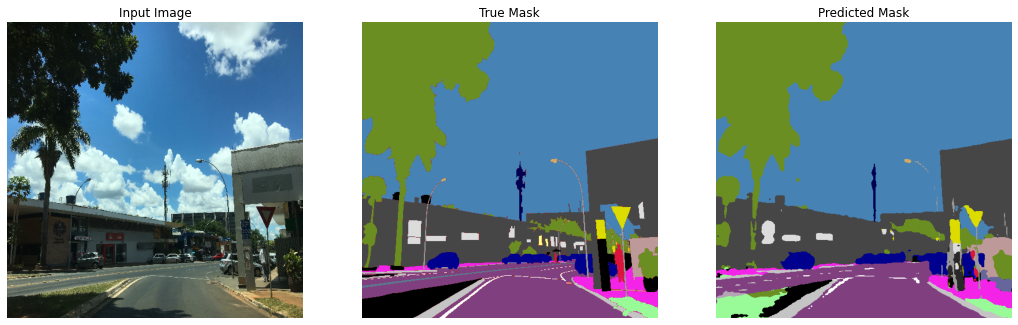


Sample Prediction after epoch 6


Epoch 00006: val_loss did not improve from 0.43363

Epoch 00006: saving model to last_weight.h5
4500/4500 [==============================] - 7048s 2s/step - loss: 0.2687 - accuracy: 0.9179 - updated_mean_io_u: 0.4793 - val_loss: 4.0751 - val_accuracy: 0.8746 - val_updated_mean_io_u: 0.3529 - lr: 0.0010
Epoch 7/15
4500/4500 [==============================] - ETA: 0s - loss: 0.2630 - accuracy: 0.9196 - updated_mean_io_u: 0.4907

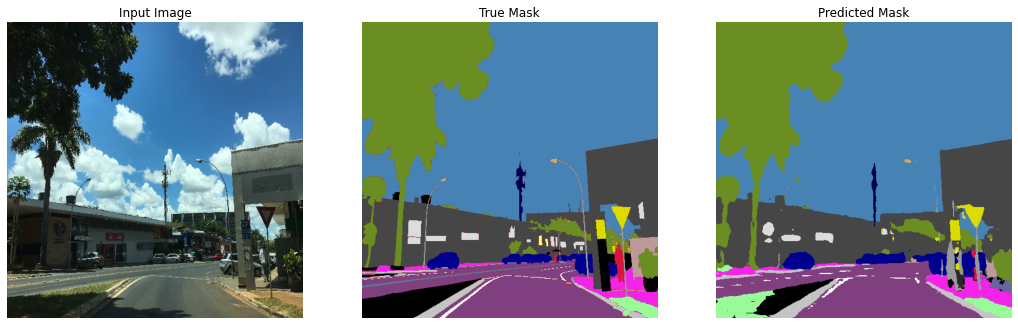


Sample Prediction after epoch 7


Epoch 00007: val_loss did not improve from 0.43363

Epoch 00007: saving model to last_weight.h5
4500/4500 [==============================] - 7163s 2s/step - loss: 0.2630 - accuracy: 0.9196 - updated_mean_io_u: 0.4907 - val_loss: 0.5614 - val_accuracy: 0.8799 - val_updated_mean_io_u: 0.3489 - lr: 0.0010
Epoch 8/15
4500/4500 [==============================] - ETA: 0s - loss: 0.2538 - accuracy: 0.9223 - updated_mean_io_u: 0.5044

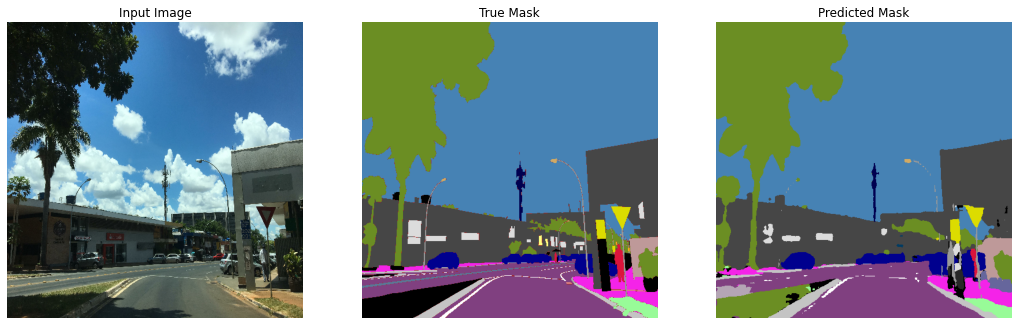


Sample Prediction after epoch 8


Epoch 00008: val_loss did not improve from 0.43363

Epoch 00008: saving model to last_weight.h5
4500/4500 [==============================] - 6848s 2s/step - loss: 0.2538 - accuracy: 0.9223 - updated_mean_io_u: 0.5044 - val_loss: 53.7559 - val_accuracy: 0.8315 - val_updated_mean_io_u: 0.3334 - lr: 0.0010
Epoch 00008: early stopping


In [ ]:
model.load_weights('best_model_deeplabv3+.h5')
model.compile(optimizer = 'Adam',
              # tfa.optimizers.RectifiedAdam(lr=1e-3),
                    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy',
                             UpdatedMeanIoU(num_classes= N_CLASSES)
                             ])
model_history2 = model.fit(dataset['train'],
                                epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=VALIDATION_STEPS,
                    validation_data=dataset['val'],
                    callbacks=callbacks
                    )